# Projet 4 - prédiction du retard d'avions
# Deuxième partie : modélisation

Les fichiers de données doivent se trouver dans le répertoire courant.

## I. Initialisation (toujours calculer cette section)

### Chargement des modules

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
import seaborn as sns
import sklearn as sk
import sklearn.dummy
import sklearn.ensemble
import sklearn.externals.joblib
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.neighbors
import sklearn.preprocessing
import sklearn.svm
import sys
import time
import warnings

FIG_SIZE = (12, 4)

# Valeur d'initialisation du générateur de nombres aléatoires
SEED = 1911

# Nom du fichier source, créé par le notebook de nettoyage
INPUT_FILE = 'flights.csv'

# Fichier dans lequel le modèle retenu sera sauvergardé
MODEL_FILENAME = 'regression_model.sav'

# Effacer le cache utilisé pour certaines fonctions lentes
CLEAR_CACHE = False

# Désactiver les modèles lents
DISABLE_GRIDSEARCH_GBR = True
DISABLE_GBR = False
DISABLE_LINEAR_SVM = True
DISABLE_GAUSSIAN_SVM = True

print(f"Version de matplotlib : {matplotlib.__version__}")
print(f"Version de pandas : {pd.__version__}")
print(f"Version de Python : {sys.version}")
print(f"Version de scikit-learn : {sk.__version__}")

Version de matplotlib : 3.0.3
Version de pandas : 0.24.2
Version de Python : 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Version de scikit-learn : 0.20.3


### Initialisation du cache

In [2]:
memory = sklearn.externals.joblib.Memory(location='./cache', verbose=0)
if CLEAR_CACHE:
    memory.clear(warn=False)
    print("Résultats des calibrations en cache effacés.")
else:
    print("Résultats des calibrations en cache préservés.")

Résultats des calibrations en cache préservés.


### Chargement des données

In [3]:
df = pd.read_csv(INPUT_FILE, sep='\t')
first_col = df.columns[0]
# Suppression de la colonne d'index
df.drop(columns=first_col, axis=0, inplace=True) 
# Conversion des dates
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'],
                               format='%Y-%m-%d',
                               errors='coerce')
print(f"Taille des données : {df.shape}")

Taille des données : (5556197, 18)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5556197 entries, 0 to 5556196
Data columns (total 18 columns):
MONTH               int64
DAY_OF_WEEK         int64
FL_DATE             datetime64[ns]
UNIQUE_CARRIER      object
ORIGIN              object
DEST                object
CRS_DEP_TIME        int64
DEP_DELAY           int64
CRS_ARR_TIME        int64
ARR_DELAY           int64
CRS_ELAPSED_TIME    int64
CRS_ARR_HOUR        int64
CRS_DEP_HOUR        int64
Z                   float64
NEXT_HOL            int64
PREV_HOL            int64
CARRIER_DELAY       float64
ORIGIN_DELAY        float64
dtypes: datetime64[ns](1), float64(3), int64(11), object(3)
memory usage: 763.0+ MB


In [5]:
df.head()

,MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,CRS_ARR_HOUR,CRS_DEP_HOUR,Z,NEXT_HOL,PREV_HOL,CARRIER_DELAY,ORIGIN_DELAY
0,1,3,2016-01-06,AA,DFW,DTW,1100,-3,1438,-6,158,14,11,-0.227477,12,5,3.451372,6.416853
1,1,4,2016-01-07,AA,DFW,DTW,1100,-4,1438,-12,158,14,11,-0.370599,11,6,3.451372,6.416853
2,1,5,2016-01-08,AA,DFW,DTW,1100,-5,1438,7,158,14,11,0.082619,10,7,3.451372,6.416853
3,1,6,2016-01-09,AA,DFW,DTW,1100,2,1438,-5,158,14,11,-0.203624,9,8,3.451372,6.416853
4,1,7,2016-01-10,AA,DFW,DTW,1100,100,1438,113,158,14,11,2.611097,8,9,3.451372,6.416853


### Réduction de l'occupation de mémoire

In [6]:
type_map = {
    'MONTH': np.int8,
    'DAY_OF_WEEK': np.int8,
    'CRS_DEP_TIME': np.int16,
    'CRS_ARR_TIME': np.int16,
    'ARR_DELAY': np.int16,
    'DEP_DELAY': np.int16,
    'CRS_ELAPSED_TIME': np.int16,
    'CRS_ARR_HOUR': np.int8,
    'CRS_DEP_HOUR': np.int8, 
    'NEXT_HOL': np.int8,
    'PREV_HOL': np.int8,
    'CARRIER_DELAY': np.float32,
    'ORIGIN_DELAY': np.float32,
    'Z': np.float32
}
df = df.astype(dtype=type_map)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5556197 entries, 0 to 5556196
Data columns (total 18 columns):
MONTH               int8
DAY_OF_WEEK         int8
FL_DATE             datetime64[ns]
UNIQUE_CARRIER      object
ORIGIN              object
DEST                object
CRS_DEP_TIME        int16
DEP_DELAY           int16
CRS_ARR_TIME        int16
ARR_DELAY           int16
CRS_ELAPSED_TIME    int16
CRS_ARR_HOUR        int8
CRS_DEP_HOUR        int8
Z                   float32
NEXT_HOL            int8
PREV_HOL            int8
CARRIER_DELAY       float32
ORIGIN_DELAY        float32
dtypes: datetime64[ns](1), float32(3), int16(5), int8(6), object(3)
memory usage: 317.9+ MB


### Conversion de la variable catégorielles `UNIQUE_CARRIER` en variables binaires
Important : créer autant d'attributs que de catégories introduirait une colinéarité parfaite (somme des indicateurs par construction égale à 1) qui rendrait la réalisation d'une régression linéaire ordinaire impossible. On omet donc volontairement 1 indicateur.

In [7]:
carriers = df['UNIQUE_CARRIER']
df = df.join(pd.get_dummies(carriers, prefix='car', drop_first=True))
print(f"Nouvelle taille des données : {df.shape}")
df.head()

Nouvelle taille des données : (5556197, 29)


,MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,...,car_B6,car_DL,car_EV,car_F9,car_HA,car_NK,car_OO,car_UA,car_VX,car_WN
0,1,3,2016-01-06,AA,DFW,DTW,1100,-3,1438,-6,...,0,0,0,0,0,0,0,0,0,0
1,1,4,2016-01-07,AA,DFW,DTW,1100,-4,1438,-12,...,0,0,0,0,0,0,0,0,0,0
2,1,5,2016-01-08,AA,DFW,DTW,1100,-5,1438,7,...,0,0,0,0,0,0,0,0,0,0
3,1,6,2016-01-09,AA,DFW,DTW,1100,2,1438,-5,...,0,0,0,0,0,0,0,0,0,0
4,1,7,2016-01-10,AA,DFW,DTW,1100,100,1438,113,...,0,0,0,0,0,0,0,0,0,0


### Création d'un attribut indicateur d'un retard de plus de 15 minutes

In [8]:
df['LATE'] = (df['ARR_DELAY'] > 15).astype(int)
print(f"Nombre de vols en retard de plus de 15 min : {sum(df['LATE'])}")
print(f"Proportion de vols en retard de plus de 15 min : {sum(df['LATE'])/len(df)*100:0.1f}%")      

Nombre de vols en retard de plus de 15 min : 932726
Proportion de vols en retard de plus de 15 min : 16.8%


### Définition d'une fonction de partitionnement des données

In [9]:
def create_sets(data,
                input_cols,
                output_cols,
                test_size=0.2,
                val_size=0.01,
                training_sample_frac=1,
                verbose=False,
                normalise=False):
    """Partitionne les données en 3 jeux, avec normalisation optionnelle."""
    X = data[input_cols].values  # Variables explicatives
    y = data[output_cols].values.ravel()
    train_size = 1 - test_size - val_size  # Taille totale des 3 jeux = 1
    # Premier partitionnement
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
        X, y, test_size=test_size, train_size=(1 - test_size), random_state=42)
    # Ajustement des taille puis 2e partitionnement
    val_size = val_size / (1 - test_size)
    train_size = train_size / (1 - test_size)
    X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(
        X_train,
        y_train,
        test_size=val_size,
        train_size=train_size * training_sample_frac,
        random_state=SEED)
    if normalise:
        # Normalisation
        ss = sk.preprocessing.RobustScaler()  
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)
        X_val = ss.transform(X_val)    
    if verbose:
        print("Variables explicatives :")
        print(input_cols)
        print(f"Taille du tableau en entrée : {X.shape}")
        print("Tailles des tableaux de données X :", X_test.shape,
              X_train.shape, X_val.shape)
        print("Tailles des tableaux de données y :", y_test.shape, 
              y_train.shape, y_val.shape)
    X = 0 # Pour libérer la mémoire
    y = 0
    return X_test, X_train, X_val, y_test, y_train, y_val

### Définition d'une fonction de création d'un jeu d'entraînement-validation pour validation croisée

In [10]:
def make_predefined_split(X_train, X_val, y_train, y_val):
    X = np.concatenate([X_train, X_val])
    y = np.concatenate([y_train, y_val])
    # Ce tableau sert à identifier les données de validation (marquées 0)
    test_fold = np.concatenate([
        np.full(X_train.shape[0], -1, dtype=np.int8), # -1 => jeu d'entraînement
        np.full(X_val.shape[0], 0, dtype=np.int8) # 0 => jeu de validation
    ])
    return X, y, sklearn.model_selection.PredefinedSplit(test_fold)

### Définition d'une fonction de création de monômes pour interpolation polynômiale

In [11]:
def prepare_polynomial_attributes(X, order, n_cols):
    """Seules les `n_cols` premières colonnes sont transformées."""
    poly = sklearn.preprocessing.PolynomialFeatures(degree=order,
                                                    include_bias=False)
    X_p = np.concatenate((poly.fit_transform(X[:, :n_cols]), X[:, n_cols:]),
                         axis=1)
    return X_p

### Suppression de colonnes non utilisées

In [12]:
delete_cols = ['Z']
df.drop(columns=delete_cols, inplace=True, errors='ignore')

## II. Régression linéaire

### Fonction de stockage des résultats

In [13]:
results = []
def add_to_results(model, order, rmse_test, rmse_train, elapsed_time):    
    results.append([model, order, rmse_test, rmse_train, elapsed_time])
    print(f"RMSE d'entraînement : {rmse_train}")
    print(f"RMSE de test : {rmse_test}")
    print(f"Temps écoulé : {elapsed_time:0.2f} s")

### Régression sans inclure les performances de T-1

In [14]:
input_cols = ['MONTH', 'DAY_OF_WEEK', 'CRS_ELAPSED_TIME', 'CRS_DEP_HOUR', 
              'CRS_ARR_HOUR', 'PREV_HOL', 'NEXT_HOL',
              'car_AS', 'car_B6', 'car_DL', 'car_EV', 'car_F9', 'car_HA', 
              'car_NK', 'car_OO', 'car_UA', 'car_VX', 'car_WN']
output_cols = ['ARR_DELAY']
test_size = 0.2  # Taille du jeu de test
val_size = 0.01  # Taille du jeu de validation
X_test, X_train, _, y_test, y_train, _ = create_sets(df,
                                                     input_cols,
                                                     output_cols,
                                                     test_size,
                                                     val_size,
                                                     normalise=False,
                                                     verbose=True)

Variables explicatives :
['MONTH', 'DAY_OF_WEEK', 'CRS_ELAPSED_TIME', 'CRS_DEP_HOUR', 'CRS_ARR_HOUR', 'PREV_HOL', 'NEXT_HOL', 'car_AS', 'car_B6', 'car_DL', 'car_EV', 'car_F9', 'car_HA', 'car_NK', 'car_OO', 'car_UA', 'car_VX', 'car_WN']
Taille du tableau en entrée : (5556197, 18)
Tailles des tableaux de données X : (1111240, 18) (4389395, 18) (55562, 18)
Tailles des tableaux de données y : (1111240,) (4389395,) (55562,)


In [15]:
start = time.time()
model = sk.linear_model.LinearRegression()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
end = time.time()

rmse_test = np.sqrt(np.mean((y_test_pred - y_test)**2))
rmse_train = np.sqrt(np.mean((y_train_pred - y_train)**2))
add_to_results('Modèle de base (variables quant., sans données T-1)', 1,
               rmse_test, rmse_train, end - start)

RMSE d'entraînement : 41.65404101418241
RMSE de test : 41.35123202887176
Temps écoulé : 4.08 s


Nous utiliserons ces résultats comme point de comparaison ('baseline') pour les autres modèles de régression.

Question : pourquoi le score est-il meilleur sur le jeu de test que sur le jeu d'entraînement ?

### Réduction de la taille du jeu d'entraînement

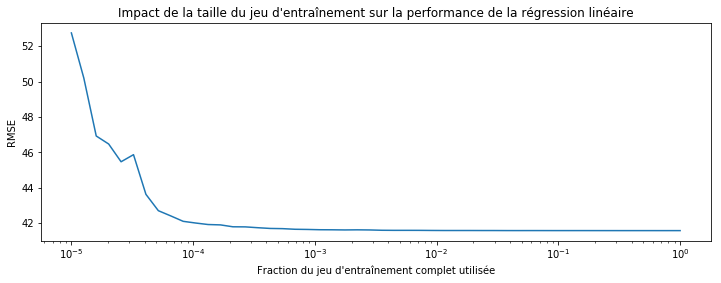

In [16]:
fractions = np.logspace(-5, 0, 50) # Valeurs à tester
errors = []
model = sk.linear_model.LinearRegression()
for frac in fractions:
    _, X_train, X_val, _, y_train, y_val = create_sets(
        df,
        input_cols,
        output_cols,
        test_size,
        val_size,
        training_sample_frac=frac,
        verbose=False)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    rmse = np.sqrt(np.mean((y_val_pred - y_val)**2))
    errors.append(rmse)
fig, axes = plt.subplots(figsize=FIG_SIZE)
sns.lineplot(x=fractions, y=errors, ax=axes)
axes.set_xscale('log')
axes.set_xlabel("Fraction du jeu d'entraînement complet utilisée")
axes.set_ylabel('RMSE');
axes.set_title("Impact de la taille du jeu d'entraînement sur la performance de la régression linéaire");

Conclusion : on peut réduire la taille du jeu d'entraînement d'un facteur 1000 sans perte de performance de la prédiction. 

### Traitement des fausses variables quantitatives en tant que variables catégorielles

In [17]:
cols = [('DAY_OF_WEEK', 'd'), ('MONTH', 'm'), ('CRS_DEP_HOUR', 'dep'), 
        ('CRS_ARR_HOUR', 'arr')]
for col, prefix in cols:
    values = df[col]
    df = df.join(pd.get_dummies(values, prefix=prefix, drop_first=True))
print(f"Nouvelle taille des données : {df.shape}")
df.head()

Nouvelle taille des données : (5556197, 92)


,MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,...,arr_14,arr_15,arr_16,arr_17,arr_18,arr_19,arr_20,arr_21,arr_22,arr_23
0,1,3,2016-01-06,AA,DFW,DTW,1100,-3,1438,-6,...,1,0,0,0,0,0,0,0,0,0
1,1,4,2016-01-07,AA,DFW,DTW,1100,-4,1438,-12,...,1,0,0,0,0,0,0,0,0,0
2,1,5,2016-01-08,AA,DFW,DTW,1100,-5,1438,7,...,1,0,0,0,0,0,0,0,0,0
3,1,6,2016-01-09,AA,DFW,DTW,1100,2,1438,-5,...,1,0,0,0,0,0,0,0,0,0
4,1,7,2016-01-10,AA,DFW,DTW,1100,100,1438,113,...,1,0,0,0,0,0,0,0,0,0


In [18]:
# Nous sélectionnons les attributs par exclusion
remove_cols = [
    'QUARTER', 'DAY_OF_MONTH', 'FL_DATE', 'UNIQUE_CARRIER', 'FL_NUM', 'ORIGIN',
    'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 'DEP_DELAY', 'ARR_DELAY',
    'PURE_ARR_DELAY', 'LATE', 'NEXT_WE', 'CRS_ARR_HOUR',
    'CRS_ARR_TIME', 'CRS_DEP_TIME', 'ORIGIN_DELAY', 'Z', 'CARRIER_DELAY',
    'MONTH', 'DAY_OF_WEEK', 'DAY', 'CRS_DEP_HOUR'
]
input_cols = [c for c in df.columns.to_list() if c not in remove_cols]
output_cols = ['ARR_DELAY']
test_size = 0.2  # taille du jeu de test
val_size = 0.01  # taille du jeu de validation
X_test, X_train, _, y_test, y_train, _ = create_sets(df,
                                                     input_cols,
                                                     output_cols,
                                                     test_size,
                                                     val_size,
                                                     training_sample_frac=0.1,
                                                     normalise=True,
                                                     verbose=True)

Variables explicatives :
['CRS_ELAPSED_TIME', 'NEXT_HOL', 'PREV_HOL', 'car_AS', 'car_B6', 'car_DL', 'car_EV', 'car_F9', 'car_HA', 'car_NK', 'car_OO', 'car_UA', 'car_VX', 'car_WN', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12', 'dep_1', 'dep_2', 'dep_3', 'dep_4', 'dep_5', 'dep_6', 'dep_7', 'dep_8', 'dep_9', 'dep_10', 'dep_11', 'dep_12', 'dep_13', 'dep_14', 'dep_15', 'dep_16', 'dep_17', 'dep_18', 'dep_19', 'dep_20', 'dep_21', 'dep_22', 'dep_23', 'arr_1', 'arr_2', 'arr_3', 'arr_4', 'arr_5', 'arr_6', 'arr_7', 'arr_8', 'arr_9', 'arr_10', 'arr_11', 'arr_12', 'arr_13', 'arr_14', 'arr_15', 'arr_16', 'arr_17', 'arr_18', 'arr_19', 'arr_20', 'arr_21', 'arr_22', 'arr_23']
Taille du tableau en entrée : (5556197, 77)
Tailles des tableaux de données X : (1111240, 77) (438939, 77) (55562, 77)
Tailles des tableaux de données y : (1111240,) (438939,) (55562,)


In [19]:
start = time.time()
model = sk.linear_model.LinearRegression()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
end = time.time()

rmse_test = np.sqrt(np.mean((y_test_pred - y_test) ** 2))
rmse_train = np.sqrt(np.mean((y_train_pred - y_train) ** 2))
add_to_results('Linéaire (variables cat., sans données T-1)', 1, 
               rmse_test, rmse_train, end-start)

RMSE d'entraînement : 41.08277169230021
RMSE de test : 41.12147207008488
Temps écoulé : 1.70 s


Conclusion : nous obtenons une meilleure performance en traitant les variables `DAY_OF_WEEK`, `MONTH` et `CRS_DEP_HOUR` comme des variables catégorielles représentées par des attributs indicateurs binaires.

### Avec les informations de T-1

In [20]:
test_size = 0.2
val_size = 0.01
remove_cols = [
    'QUARTER', 'DAY_OF_MONTH', 'FL_DATE', 'UNIQUE_CARRIER', 'FL_NUM', 'ORIGIN',
    'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 'DEP_DELAY', 'ARR_DELAY',
    'PURE_ARR_DELAY', 'LATE', 'NEXT_WE',
    'CRS_DEP_TIME', 'CRS_ARR_TIME', 'Z', 'MONTH', 'DAY_OF_WEEK',
    'CRS_ARR_HOUR', 'DAY', 'CRS_DEP_HOUR'
]
input_cols = [c for c in df.columns.to_list() if c not in remove_cols]
output_cols = ['ARR_DELAY']
X_test, X_train, X_val, y_test, y_train, y_val = create_sets(
    df,
    input_cols,
    output_cols,
    test_size,
    val_size,
    training_sample_frac=0.1,
    normalise=False,
    verbose=True)

Variables explicatives :
['CRS_ELAPSED_TIME', 'NEXT_HOL', 'PREV_HOL', 'CARRIER_DELAY', 'ORIGIN_DELAY', 'car_AS', 'car_B6', 'car_DL', 'car_EV', 'car_F9', 'car_HA', 'car_NK', 'car_OO', 'car_UA', 'car_VX', 'car_WN', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12', 'dep_1', 'dep_2', 'dep_3', 'dep_4', 'dep_5', 'dep_6', 'dep_7', 'dep_8', 'dep_9', 'dep_10', 'dep_11', 'dep_12', 'dep_13', 'dep_14', 'dep_15', 'dep_16', 'dep_17', 'dep_18', 'dep_19', 'dep_20', 'dep_21', 'dep_22', 'dep_23', 'arr_1', 'arr_2', 'arr_3', 'arr_4', 'arr_5', 'arr_6', 'arr_7', 'arr_8', 'arr_9', 'arr_10', 'arr_11', 'arr_12', 'arr_13', 'arr_14', 'arr_15', 'arr_16', 'arr_17', 'arr_18', 'arr_19', 'arr_20', 'arr_21', 'arr_22', 'arr_23']
Taille du tableau en entrée : (5556197, 79)
Tailles des tableaux de données X : (1111240, 79) (438939, 79) (55562, 79)
Tailles des tableaux de données y : (1111240,) (438939,) (55562,)


In [21]:
start = time.time()
model = sk.linear_model.LinearRegression()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
end = time.time()

rmse_test = math.sqrt(sk.metrics.mean_squared_error(y_test, y_test_pred))
rmse_train = math.sqrt(sk.metrics.mean_squared_error(y_train, y_train_pred))
add_to_results('Linéaire (variables cat., avec données T-1)', 1, rmse_test,
               rmse_train, end - start)

RMSE d'entraînement : 41.06716256110607
RMSE de test : 41.10756956316713
Temps écoulé : 1.27 s


La performance s'améliore, mais le gain est faible.

### Sauvegarde du modèle

In [22]:
pickle.dump(model, open(MODEL_FILENAME, 'wb'))

### Exemple pour tester le serveur

In [23]:
# Extraction d'une ligne de données
idx = 1
x = df[input_cols].loc[[idx], :].values

# Calcul et affichage
print(f"Prévision : {model.predict(x)[0]}")
df.loc[idx, [
    'FL_DATE', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'ORIGIN', 'CRS_ELAPSED_TIME', 'UNIQUE_CARRIER',
    'ORIGIN_DELAY', 'CARRIER_DELAY'
]]

Prévision : 2.8972654342651367


FL_DATE             2016-01-07 00:00:00
CRS_DEP_TIME                       1100
CRS_ARR_TIME                       1438
ORIGIN                              DFW
CRS_ELAPSED_TIME                    158
UNIQUE_CARRIER                       AA
ORIGIN_DELAY                    6.41685
CARRIER_DELAY                   3.45137
Name: 1, dtype: object

### Régression après exclusion des valeurs extrêmes du jeu d'entraînement

In [24]:
Z = 10
mask = np.abs(y_train - np.mean(y_train)) <= Z * np.std(y_train)
print(f"Nombre d'entrées conservées : {sum(mask)}")
print(f"Nombre d'entrées ignorées : {sum(~mask)}")
start = time.time()
X_train_reduced = X_train[mask]
y_train_reduced = y_train[mask]
model.fit(X_train_reduced, y_train_reduced)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train_reduced)
end = time.time()

rmse_test = np.sqrt(np.mean((y_test_pred - y_test)**2))
rmse_train = np.sqrt(np.mean((y_train_pred - y_train_reduced)**2))
add_to_results('Linéaire sans valeurs extrêmes (variables cat., données T-1)', 1, rmse_test,
               rmse_train, end - start)

Nombre d'entrées conservées : 438545
Nombre d'entrées ignorées : 394
RMSE d'entraînement : 35.36872100830078
RMSE de test : 41.112083435058594
Temps écoulé : 1.19 s


## III. Régression par arbre de décision

In [25]:
test_size = 0.2 
val_size = 0.01
remove_cols = [
    'QUARTER', 'DAY_OF_MONTH', 'FL_DATE', 'UNIQUE_CARRIER', 'FL_NUM', 'ORIGIN',
    'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 'DEP_DELAY', 'ARR_DELAY',
    'PURE_ARR_DELAY', 'LATE', 'NEXT_WE',
    'CRS_DEP_TIME', 'CRS_ARR_TIME', 'Z', 'MONTH', 'DAY_OF_WEEK',
    'CRS_ARR_HOUR', 'DAY', 'CRS_DEP_HOUR'
]
input_cols = [c for c in df.columns.to_list() if c not in remove_cols]
output_cols = ['ARR_DELAY']
X_test, X_train, X_val, y_test, y_train, y_val = create_sets(
    df,
    input_cols,
    output_cols,
    test_size,
    val_size,
    training_sample_frac=0.1,
    normalise=True,
    verbose=True)

Variables explicatives :
['CRS_ELAPSED_TIME', 'NEXT_HOL', 'PREV_HOL', 'CARRIER_DELAY', 'ORIGIN_DELAY', 'car_AS', 'car_B6', 'car_DL', 'car_EV', 'car_F9', 'car_HA', 'car_NK', 'car_OO', 'car_UA', 'car_VX', 'car_WN', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12', 'dep_1', 'dep_2', 'dep_3', 'dep_4', 'dep_5', 'dep_6', 'dep_7', 'dep_8', 'dep_9', 'dep_10', 'dep_11', 'dep_12', 'dep_13', 'dep_14', 'dep_15', 'dep_16', 'dep_17', 'dep_18', 'dep_19', 'dep_20', 'dep_21', 'dep_22', 'dep_23', 'arr_1', 'arr_2', 'arr_3', 'arr_4', 'arr_5', 'arr_6', 'arr_7', 'arr_8', 'arr_9', 'arr_10', 'arr_11', 'arr_12', 'arr_13', 'arr_14', 'arr_15', 'arr_16', 'arr_17', 'arr_18', 'arr_19', 'arr_20', 'arr_21', 'arr_22', 'arr_23']
Taille du tableau en entrée : (5556197, 79)
Tailles des tableaux de données X : (1111240, 79) (438939, 79) (55562, 79)
Tailles des tableaux de données y : (1111240,) (438939,) (55562,)


### Arbre simple

In [26]:
X, y, ps = make_predefined_split(X_train, X_val, y_train, y_val)
base = sk.tree.DecisionTreeRegressor(random_state=42)
grid = {'max_depth': [10, 20, 25, 30, 35, 40], 
        'min_samples_leaf': [50, 100, 250, 500, 750, 1000]}
model = sk.model_selection.GridSearchCV(base, param_grid=grid, cv=ps,
                                            n_jobs=2)
model.fit(X, y)
model.best_params_

{'max_depth': 25, 'min_samples_leaf': 100}

In [27]:
start = time.time()
max_depth = 30
min_samples = 500
model = sk.tree.DecisionTreeRegressor(random_state=42,
                                      min_samples_leaf=min_samples,
                                      max_depth=max_depth)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
end = time.time()
rmse_test = np.sqrt(np.mean((y_test_pred - y_test)**2))
rmse_train = np.sqrt(np.mean((y_train_pred - y_train)**2))
add_to_results('Arbre de décision (variables cat., données T-1)', 1, rmse_test,
               rmse_train, end - start)

RMSE d'entraînement : 40.45994748146468
RMSE de test : 40.68126583109493
Temps écoulé : 10.86 s


### Gradient boosting

In [28]:
if DISABLE_GRIDSEARCH_GBR:
    print("Modèle GBR désactivé")
else:
    X, y, ps = make_predefined_split(X_train, X_val, y_train, y_val)
    base = sk.ensemble.GradientBoostingRegressor(random_state=SEED)
    grid = {'n_estimators': [10, 50, 75],
            'max_depth': [20, 50, 100], 
            'min_samples_split': [100, 500, 1000],
            'min_samples_leaf': [100, 500]}
    model = sk.model_selection.GridSearchCV(base, 
                                            param_grid=grid, 
                                            cv=ps,
                                            n_jobs=-1)
    model.fit(X, y)
    print(model.best_params_)

Modèle GBR désactivé


Sauvegarde des résultats: 
{'max_depth': 20,
 'min_samples_leaf': 100,
 'min_samples_split': 500,
 'n_estimators': 50}

In [29]:
if DISABLE_GBR:
    print("Modèle GBR désactivé")
else:
    max_depth = 20
    min_split = 500
    min_leaf = 100
    n_estimators = 50
    start = time.time()
    model = sk.ensemble.GradientBoostingRegressor(n_estimators=n_estimators, 
                                                  max_depth=max_depth, 
                                                  min_samples_leaf=min_leaf,
                                                  min_samples_split=min_split)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    end = time.time()
    rmse_test = np.sqrt(np.mean((y_test_pred - y_test)**2))
    rmse_train = np.sqrt(np.mean((y_train_pred - y_train)**2))
    add_to_results('GBR (variables cat., données T-1)', 1, 
                   rmse_test, rmse_train, end - start)

RMSE d'entraînement : 38.21700647203435
RMSE de test : 39.74930656937759
Temps écoulé : 1923.16 s


## IV. Régression polynômiale

Comme nous augmentons le nombre de variables, il est nécessaire d'introduire un mécanisme de régularisation.

In [30]:
output_cols = ['ARR_DELAY']
test_size = 0.2  # taille du jeu de test
val_size = 0.2  # taille du jeu de validation
X_test, X_train, X_val, y_test, y_train, y_val = create_sets(
    df,
    input_cols,
    output_cols,
    test_size,
    val_size,
    training_sample_frac=0.01,
    normalise=True,
    verbose=True)

Variables explicatives :
['CRS_ELAPSED_TIME', 'NEXT_HOL', 'PREV_HOL', 'CARRIER_DELAY', 'ORIGIN_DELAY', 'car_AS', 'car_B6', 'car_DL', 'car_EV', 'car_F9', 'car_HA', 'car_NK', 'car_OO', 'car_UA', 'car_VX', 'car_WN', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12', 'dep_1', 'dep_2', 'dep_3', 'dep_4', 'dep_5', 'dep_6', 'dep_7', 'dep_8', 'dep_9', 'dep_10', 'dep_11', 'dep_12', 'dep_13', 'dep_14', 'dep_15', 'dep_16', 'dep_17', 'dep_18', 'dep_19', 'dep_20', 'dep_21', 'dep_22', 'dep_23', 'arr_1', 'arr_2', 'arr_3', 'arr_4', 'arr_5', 'arr_6', 'arr_7', 'arr_8', 'arr_9', 'arr_10', 'arr_11', 'arr_12', 'arr_13', 'arr_14', 'arr_15', 'arr_16', 'arr_17', 'arr_18', 'arr_19', 'arr_20', 'arr_21', 'arr_22', 'arr_23']
Taille du tableau en entrée : (5556197, 79)
Tailles des tableaux de données X : (1111240, 79) (33337, 79) (1111240, 79)
Tailles des tableaux de données y : (1111240,) (33337,) (1111240,)


### Régression Ridge

#### Optimisation de l'hyperparamètre de régularisation et du degré du polynôme

Ordre 4 : minimum 41.142 atteint au point 1291.5496650148852
Ordre 3 : minimum 40.998 atteint au point 200.923300256505
Ordre 2 : minimum 41.001 atteint au point 200.923300256505


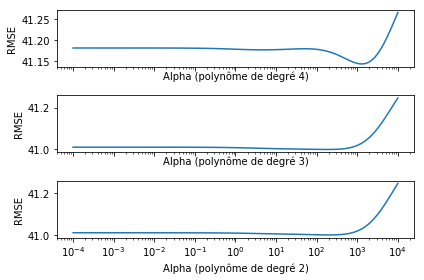

In [31]:
orders = [4, 3, 2]
alphas = np.logspace(-4, 4, 100)
min_alphas = []
n_poly_cols = 5
model = sk.linear_model.Ridge(random_state=42)
fig, axes = plt.subplots(len(orders), 1, sharex=True)
i = 0
for order in orders:    
    # Création des jeux de données
    X_train_p = prepare_polynomial_attributes(X_train, order, n_poly_cols)
    X_test_p = prepare_polynomial_attributes(X_test, order, n_poly_cols)
    X_val_p = prepare_polynomial_attributes(X_val, order, n_poly_cols)
    # Recherche du meilleur alpha   
    errors = []
    min_rmse = 1e10
    min_alpha = 0    
    for alpha in alphas:
        model.set_params(alpha=alpha)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=scipy.linalg.LinAlgWarning)
            model.fit(X_train_p, y_train)
        rmse = np.sqrt(np.mean((model.predict(X_val_p) - y_val)**2))
        if (rmse < min_rmse):
            min_rmse = rmse
            min_alpha = alpha
        errors.append(rmse)
    print(f"Ordre {order} : minimum {min_rmse:.3f} atteint au point {min_alpha}")  
    min_alphas.append(min_alpha)
    sns.lineplot(x=alphas, y=errors, ax=axes[i]);    
    axes[i].set_xlabel(f"Alpha (polynôme de degré {order})");
    axes[i].set_ylabel('RMSE');
    axes[i].set_xscale('log');
    y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
    axes[i].yaxis.set_major_formatter(y_formatter)
    i = i + 1
fig.tight_layout();

Le gain en performance obtenu en augmentant l'ordre du polynôme de 2 à 4 est très faible et il ne semble pas justifié d'augmenter la complexité du modèle pour une amélioration aussi faible.

#### Vérification en utilisant la fonction RidgCV()

In [32]:
order = 2
n_poly_cols = 5
X_train_p = prepare_polynomial_attributes(X_train, order, n_poly_cols)
X_test_p = prepare_polynomial_attributes(X_test, order, n_poly_cols)
X_val_p = prepare_polynomial_attributes(X_val, order, n_poly_cols)
X, y, ps = make_predefined_split(X_train_p, X_val_p, y_train, y_val)
model = sklearn.linear_model.RidgeCV(alphas = np.logspace(-4, 4, 100), cv=ps)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=scipy.linalg.LinAlgWarning)
    model.fit(X, y)
print(f"Alpha pour une interpolation de degré {order} : {model.alpha_}")

Alpha pour une interpolation de degré 2 : 200.923300256505


On retrouve bien le même résultat : notre implémentation est correcte.

#### Enregistrement de la performance

In [33]:
n_poly_cols = 5
for (order, alpha) in zip(orders, min_alphas):
    X_train_p = prepare_polynomial_attributes(X_train, order, n_poly_cols)
    X_test_p = prepare_polynomial_attributes(X_test, order, n_poly_cols)
    start = time.time()
    model = sk.linear_model.Ridge(alpha=alpha, random_state=42)
    model.fit(X_train_p, y_train)
    y_test_pred = model.predict(X_test_p)
    y_train_pred = model.predict(X_train_p)    
    end = time.time()
    
    rmse_test = np.sqrt(np.mean((y_test_pred - y_test)**2))
    rmse_train = np.sqrt(np.mean((y_train_pred - y_train)**2))
    add_to_results('Ridge (variables cat., données T-1)', order, rmse_test, rmse_train, 
                   end-start)

RMSE d'entraînement : 41.53133773803711
RMSE de test : 41.89052963256836
Temps écoulé : 0.30 s
RMSE d'entraînement : 41.55631637573242
RMSE de test : 41.18492126464844
Temps écoulé : 0.20 s
RMSE d'entraînement : 41.606014251708984
RMSE de test : 41.13015365600586
Temps écoulé : 0.14 s


### Régression LASSO

#### Optimisation de l'hyperparamètre de régularisation et du degré du polynôme

Ordre 4 : minimum 41.099 atteint au point 0.08111308307896872
Ordre 3 : minimum 40.997 atteint au point 0.015199110829529346
Ordre 2 : minimum 41.000 atteint au point 0.015199110829529346


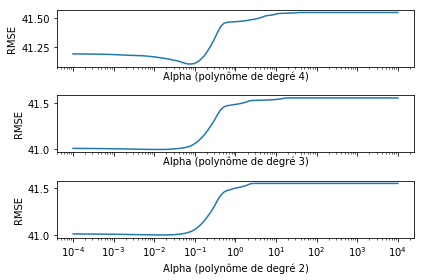

In [34]:
orders = [4, 3, 2]
alphas = np.logspace(-4, 4, 100)
n_poly_cols = 5
min_alphas = []
model = sk.linear_model.Lasso(random_state=42)
fig, axes = plt.subplots(len(orders), 1, sharex=True)
i = 0
for order in orders:
    # Création des jeux de données    
    X_train_p = prepare_polynomial_attributes(X_train, order, n_poly_cols)
    X_test_p = prepare_polynomial_attributes(X_test, order, n_poly_cols)
    X_val_p = prepare_polynomial_attributes(X_val, order, n_poly_cols)
    # Recherche du meilleur alpha
    errors = []
    min_rmse = 1e10
    min_alpha = 0
    for alpha in alphas:
        model.set_params(alpha=alpha)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train_p, y_train)
        y_val_pred = model.predict(X_val_p)
        rmse = np.sqrt(np.mean((y_val_pred - y_val)**2))
        if (rmse < min_rmse):
            min_rmse = rmse
            min_alpha = alpha
        errors.append(rmse)
    print(f"Ordre {order} : minimum {min_rmse:.3f} atteint "
          f"au point {min_alpha}")
    min_alphas.append(min_alpha)
    sns.lineplot(x=alphas, y=errors, ax=axes[i])
    axes[i].set_xlabel(f"Alpha (polynôme de degré {order})")
    axes[i].set_ylabel('RMSE')
    axes[i].set_xscale('log')
    y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
    axes[i].yaxis.set_major_formatter(y_formatter)
    i = i + 1
fig.tight_layout()

#### Enregistrement de la performance

In [35]:
for (order, alpha) in zip(orders, min_alphas):
    X_train_p = prepare_polynomial_attributes(X_train, order, n_poly_cols)
    X_test_p = prepare_polynomial_attributes(X_test, order, n_poly_cols)
    start = time.time()
    model = sk.linear_model.Lasso(alpha=alpha, random_state=42)
    model.fit(X_train_p, y_train)
    y_test_pred = model.predict(X_test_p)
    y_train_pred = model.predict(X_train_p)
    end = time.time()
    rmse_test = np.sqrt(np.mean((y_test_pred - y_test)**2))
    rmse_train = np.sqrt(np.mean((y_train_pred - y_train)**2))
    n_zeros = np.count_nonzero(model.coef_ == 0)
    print(f"Nombre de coefficients nuls au degré {order} : "
          f"{n_zeros} sur {len(model.coef_)}")
    add_to_results('Lasso avec données T-1', order, rmse_test, rmse_train, 
                   end-start)

Nombre de coefficients nuls au degré 4 : 87 sur 199
RMSE d'entraînement : 41.572139739990234
RMSE de test : 41.91558837890625
Temps écoulé : 1.70 s
Nombre de coefficients nuls au degré 3 : 25 sur 129
RMSE d'entraînement : 41.5569953918457
RMSE de test : 41.181854248046875
Temps écoulé : 1.60 s
Nombre de coefficients nuls au degré 2 : 20 sur 94
RMSE d'entraînement : 41.60688781738281
RMSE de test : 41.129241943359375
Temps écoulé : 0.25 s


### Régression Elastic-Net

#### Optimisation de l'hyperparamètre de régularisation et du degré du polynôme

Ordre 4 : minimum 41.124 atteint au point 0.055908101825122285
Ordre 3 : minimum 40.998 atteint au point 0.007220809018385471
Ordre 2 : minimum 41.001 atteint au point 0.008697490026177835


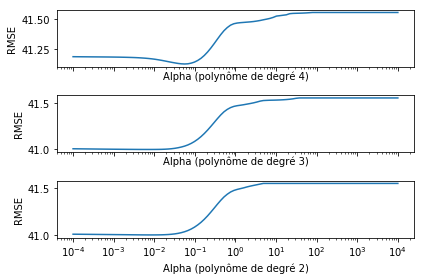

In [36]:
alphas = np.logspace(-4, 4, 100)
orders = [4, 3, 2]
n_poly_cols = 5
model = sk.linear_model.ElasticNet(random_state=42)
min_alphas = []
fig, axes = plt.subplots(len(orders), 1, sharex=True)
i = 0
for order in orders:
    # Création des jeux de données    
    X_train_p = prepare_polynomial_attributes(X_train, order, n_poly_cols)
    X_test_p = prepare_polynomial_attributes(X_test, order, n_poly_cols)
    X_val_p = prepare_polynomial_attributes(X_val, order, n_poly_cols)
    # Recherche du meilleur alpha
    errors = []
    min_rmse = 1e10
    min_alpha = 0
    for alpha in alphas:
        model.set_params(alpha=alpha)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train_p, y_train)
        y_val_pred = model.predict(X_val_p)
        rmse = np.sqrt(np.mean((y_val_pred - y_val)**2))
        if (rmse < min_rmse):
            min_rmse = rmse
            min_alpha = alpha
        errors.append(rmse)
    print(f"Ordre {order} : minimum {min_rmse:.3f} atteint au point {min_alpha}")    
    min_alphas.append(min_alpha)
    sns.lineplot(x=alphas, y=errors, ax=axes[i]);    
    axes[i].set_xlabel(f"Alpha (polynôme de degré {order})");
    axes[i].set_ylabel('RMSE');
    axes[i].set_xscale('log');
    y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
    axes[i].yaxis.set_major_formatter(y_formatter)
    i = i + 1
fig.tight_layout();

#### Enregistrement de la performance

In [37]:
for (order, alpha) in zip(orders, min_alphas):
    X_train_p = prepare_polynomial_attributes(X_train, order, n_poly_cols)
    X_test_p = prepare_polynomial_attributes(X_test, order, n_poly_cols)
    start = time.time()
    model = sk.linear_model.ElasticNet(alpha=alpha, random_state=42)
    model.fit(X_train_p, y_train)
    y_test_pred = model.predict(X_test_p)
    y_train_pred = model.predict(X_train_p)
    end = time.time()
    
    rmse_test = np.sqrt(np.mean((y_test_pred - y_test)**2))
    rmse_train = np.sqrt(np.mean((y_train_pred - y_train)**2))
    add_to_results('ElasticNet (variables cat., données T-1)', order, rmse_test, 
                   rmse_train, end-start)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RMSE d'entraînement : 41.54930114746094
RMSE de test : 42.22990798950195
Temps écoulé : 3.53 s
RMSE d'entraînement : 41.554893493652344
RMSE de test : 41.18552780151367
Temps écoulé : 1.75 s
RMSE d'entraînement : 41.60626220703125
RMSE de test : 41.130165100097656
Temps écoulé : 0.27 s


## V. Régression KNN

### Préparation et normalisation des données

In [38]:
remove_cols = [
    'QUARTER', 'DAY_OF_MONTH', 'FL_DATE', 'UNIQUE_CARRIER', 'FL_NUM', 'ORIGIN',
    'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 'DEP_DELAY', 'ARR_DELAY',
    'PURE_ARR_DELAY', 'LATE', 'NEXT_WE',
    'CRS_DEP_HOUR', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'Z', 'MONTH',
    'DAY_OF_WEEK', 'CRS_ARR_HOUR', 'DAY'
]
input_cols = [c for c in df.columns.to_list() if c not in remove_cols]
output_cols = ['ARR_DELAY']
test_size = 0.2
val_size = 0.01
X_test, X_train, X_val, y_test, y_train, y_val = create_sets(
    df,
    input_cols,
    output_cols,
    test_size,
    val_size,
    training_sample_frac=0.01,
    verbose=True,
    normalise=True)

Variables explicatives :
['CRS_ELAPSED_TIME', 'NEXT_HOL', 'PREV_HOL', 'CARRIER_DELAY', 'ORIGIN_DELAY', 'car_AS', 'car_B6', 'car_DL', 'car_EV', 'car_F9', 'car_HA', 'car_NK', 'car_OO', 'car_UA', 'car_VX', 'car_WN', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12', 'dep_1', 'dep_2', 'dep_3', 'dep_4', 'dep_5', 'dep_6', 'dep_7', 'dep_8', 'dep_9', 'dep_10', 'dep_11', 'dep_12', 'dep_13', 'dep_14', 'dep_15', 'dep_16', 'dep_17', 'dep_18', 'dep_19', 'dep_20', 'dep_21', 'dep_22', 'dep_23', 'arr_1', 'arr_2', 'arr_3', 'arr_4', 'arr_5', 'arr_6', 'arr_7', 'arr_8', 'arr_9', 'arr_10', 'arr_11', 'arr_12', 'arr_13', 'arr_14', 'arr_15', 'arr_16', 'arr_17', 'arr_18', 'arr_19', 'arr_20', 'arr_21', 'arr_22', 'arr_23']
Taille du tableau en entrée : (5556197, 79)
Tailles des tableaux de données X : (1111240, 79) (43893, 79) (55562, 79)
Tailles des tableaux de données y : (1111240,) (43893,) (55562,)


### Optimisation de l'hyperparamètre K

In [39]:
@memory.cache
def gridsearch_knn(X, y, K_values, cv): 
    base = sk.neighbors.KNeighborsRegressor()
    grid = {'n_neighbors': K_values,
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
           }
    model = sk.model_selection.GridSearchCV(base,
                                            param_grid=grid,
                                            cv=cv,
                                            n_jobs=-1,
                                            verbose=1)
    model.fit(X, y)
    return model.best_params_

In [40]:
X, y, ps = make_predefined_split(X_train, X_val, y_train, y_val)
K_values = [50, 100, 150] # Pas assez de mémoire pour valeurs supérieures
best_params = gridsearch_knn(X, y, K_values, cv=ps)
best_params

Fitting 1 folds for each of 12 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 37.9min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 40.0min finished


{'metric': 'manhattan', 'n_neighbors': 150, 'weights': 'distance'}

### Entraînement et évaluation du modèle

In [41]:
K = 150
metric='manhattan'
weights='uniform'
start = time.time()
model = sk.neighbors.KNeighborsRegressor(n_jobs=-1,
                                         n_neighbors=K,
                                         metric=metric,
                                         weights=weights)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
end = time.time()

rmse_test = np.sqrt(np.mean((y_test_pred - y_test) ** 2))
rmse_train = np.sqrt(np.mean((y_train_pred - y_train) ** 2))
add_to_results('K-NN (variables cat., données T-1)', 1, rmse_test, rmse_train, end-start)

RMSE d'entraînement : 40.04445238869452
RMSE de test : 41.016283733247825
Temps écoulé : 2117.31 s


La régression KNN est simple à paramétrer et à implémenter, mais gourmande en temps de calcul et pas significativement plus performante qu'une simple régression linéaire. 

## VI. Comparaison des modèles de régression

,durée,RMSE_train,RMSE,degré,modèle
0,4.078417,41.654041,41.351232,1,"Modèle de base (variables quant., sans données..."
1,1.703002,41.082772,41.121472,1,"Linéaire (variables cat., sans données T-1)"
2,1.265785,41.067163,41.107570,1,"Linéaire (variables cat., avec données T-1)"
3,1.187541,35.368721,41.112083,1,Linéaire sans valeurs extrêmes (variables cat....
4,10.860110,40.459947,40.681266,1,"Arbre de décision (variables cat., données T-1)"
5,1923.161160,38.217006,39.749307,1,"GBR (variables cat., données T-1)"
6,0.298829,41.531338,41.890530,4,"Ridge (variables cat., données T-1)"
7,0.200891,41.556316,41.184921,3,"Ridge (variables cat., données T-1)"
8,0.143921,41.606014,41.130154,2,"Ridge (variables cat., données T-1)"
9,1.702556,41.572140,41.915588,4,Lasso avec données T-1


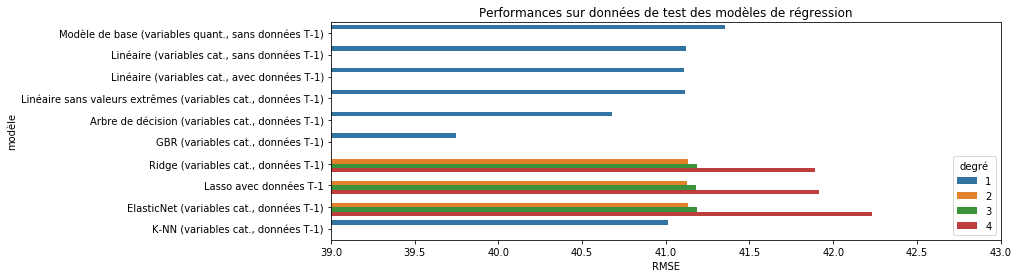

In [42]:
columns=['modèle', 'degré', 'RMSE', 'RMSE_train', 'durée']
res_df = pd.DataFrame(results, columns=columns)
fig, axes = plt.subplots(figsize=FIG_SIZE)
sns.barplot(data=res_df, y='modèle', x='RMSE', hue='degré')
axes.set_xlim(left=int(res_df['RMSE'].min()),
              right=int(res_df['RMSE'].max() + 1))
axes.set_title("Performances sur données de test des modèles de régression")
res_df[list(res_df.columns)[::-1]]  # Inverse l'ordre des colonnes

Remarques :
- La régression Lasso est utile lorsque le nombre de prédicteurs est très élevé, car elle va en éliminer, ce qui n'est pas le cas ici.
- La régression Ridge ne réalise pas de sélection, mais évite le surapprentissage en pénalisant les coefficients élevés.
- L'utilisation de polynômes d'interpolation d'ordre supérieur à 2 conduit à du surapprentissage.

In [43]:
# Arrêt de l'exécution
class StopExecution(Exception):
    """Base class for exceptions in this module."""
    pass

raise StopExecution("Arrêt de l'exécution")

StopExecution: Arrêt de l'exécution

## VII. Régression logistique à 2 classes

### Préparation des jeux de données

In [ ]:
remove_cols = [
    'QUARTER', 'DAY_OF_MONTH', 'FL_DATE', 'UNIQUE_CARRIER', 'FL_NUM', 'ORIGIN',
    'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 'DEP_DELAY', 'ARR_DELAY',
    'PURE_ARR_DELAY', 'LATE', 'NEXT_HOL', 'PREV_HOL', 'NEXT_WE',
    'CRS_DEP_TIME', 'CRS_ARR_TIME', 'Z', 'MONTH', 'DAY_OF_WEEK', 'CRS_DEP_HOUR'
]
input_cols = [c for c in df.columns.to_list() if c not in remove_cols]
output_cols = ['LATE']
X_test, X_train, X_val, y_test, y_train, y_val = create_sets(
    df,
    input_cols,
    output_cols,
    test_size=0.2,
    val_size=0.01,
    training_sample_frac=0.01,
    verbose=True,
    normalise=True)

### Optimisation de l'hyperparamètre C - méthode manuelle

In [ ]:
@memory.cache
def calibrate_logistic_reg(c_values, solver, max_iter, verbose=False):
    scores = []
    max_score = 0
    for c in c_values:
        # Calibration
        model = sk.linear_model.LogisticRegression(C=c,
                                                   random_state=42,
                                                   solver=solver,
                                                   max_iter=max_iter,
                                                   class_weight='balanced')
        model.fit(X_train, y_train.ravel())
        # Enregistrement des résultats
        y_val_predicted = model.predict(X_val)
        score = sk.metrics.f1_score(y_val, y_val_predicted)
        scores.append(score)
        if score > max_score:
            max_score = score
            max_c = c
            if verbose:
                print(f"Nouveau maximum ({max_score:0.4f}) atteint "
                      f"au point c = {max_c:0.4f}")
    return scores, max_score, max_c

In [ ]:
c_values = np.logspace(np.log10(0.001), np.log10(1000), 100)
solver = 'sag'
max_iter = 1000
scores, max_score, max_c = calibrate_logistic_reg(c_values,
                                                  solver,
                                                  max_iter,
                                                  verbose=False)
print(f"Maximum {max_score} atteint au point {max_c}.")

In [ ]:
# Représentation graphique des résultats
fig, axes = plt.subplots(figsize=FIG_SIZE)
sns.lineplot(c_values, scores)
axes.set_xscale('log')
axes.set_xlabel('Paramètre de régularisation C');
axes.set_ylabel('Score F1');

### Comparaison du score F1 avec un modèle naïf
Avec un modèle pour lequel $P(0) = P(1) = 0,5$, on obtient une précision de $0,17$ (proportion de retards) et un rappel de $0,5$. Donc $F1 = 0,254$.
Vérification :

In [ ]:
model = sklearn.dummy.DummyClassifier(strategy='prior', random_state=42)
model.fit(X_train, y_train)
y_val_predicted = model.predict(X_val)
print(sk.metrics.classification_report(y_val, y_val_predicted))

Notre score F1 indique donc un modèle avec une performance correcte.

### Optimisation de l'hyperparamètre C - utilisation de `GridSearchCV` sans validation croisée

In [ ]:
def gridsearch_logistic_regression(X, y, c_values, solver, max_iter, cv):
    base = sk.linear_model.LogisticRegression(random_state=42,
                                              solver=solver,
                                              max_iter=max_iter,
                                              class_weight='balanced')
    grid = {"C": c_values, 'class_weight': [None, 'balanced']}
    model = sk.model_selection.GridSearchCV(base,
                                            param_grid=grid,
                                            cv=cv,
                                            n_jobs=-1,
                                            scoring='f1')
    model.fit(X, y)
    return model.best_params_

In [ ]:
X, y, ps = make_predefined_split(X_train, X_val, y_train, y_val)
c_values = np.logspace(np.log10(0.001), np.log10(1000), 100)
best_params = gridsearch_logistic_regression(X,
                                             y,
                                             c_values=c_values,
                                             solver='sag',
                                             max_iter=1000,
                                             cv=ps)
print(f"Valeurs optimales des hyperparamètres : {best_params}")

### Optimisation de l'hyperparamètre C - utilisation de `GridSearchCV` avec validation croisée

In [ ]:
c_values = np.logspace(np.log10(0.001), np.log10(1000), 100)
best_params = gridsearch_logistic_regression(X_train,
                                             y_train,
                                             c_values,
                                             'sag',
                                             1000,
                                             cv=10)
print(f"Valeurs optimales des hyperparamètres : {best_params}")

{'C': 0.0013219411484660286, 'class_weight': 'balanced'}

Pourquoi obtenons-nous une valeur optimale de C différente de l'optimisation manuelle ? 

### Entraînement et évaluation du modèle

In [ ]:
model = sk.linear_model.LogisticRegression(C=max_c,
                                           random_state=42,
                                           solver='sag',
                                           class_weight='balanced')
model.fit(X_train, y_train.ravel())
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)
print("Rapport de classification pour les données d'apprentissage :")
print(sk.metrics.classification_report(y_train, y_train_predicted))
print("Rapport de classification pour les données de test :")
print(sk.metrics.classification_report(y_test, y_test_predicted))

Nous préférons un faux positif (retard prédit, avion à l'heure) à un faux négatif (avion attendu à l'heure, mais en retard).

Ce qui nous conduit à rechercher un score de rappel élevé pour la catégorie 1.

In [ ]:
y_prob = model.predict_proba(X_test)[:, 1]
[fpr, tpr, threshold] = sk.metrics.roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='red') # sns.lineplot() est trop lent
plt.plot([0, 1], [0, 1], linestyle='--')
print(f"AUC = {sk.metrics.auc(fpr, tpr)}")

La performance est meilleure qu'un modèle naïf, mais néanmoins insatisfaisante.

## VIII. Classement par SVM à noyau

### Création de plusieurs classes de retard

In [ ]:
def delay_class(delay):
    if delay <= 15:
        return 0 # Vol à l'heure ou en avance
    elif delay <= 60:
        return 1 # Retard de moins d'une heure
    else:
        return 2 # Retard de plus d'une heure


df['LATE'] = df['ARR_DELAY'].apply(delay_class)
total = len(df)
for c in range(0, 3):
    count = sum(df['LATE'] == c)
    print(f"Nombre de vols de catégorie {c} :"
          f" {count} ({count/total*100:0.2f}%)")

Les différences de cardinalité des 3 classes pourront poser problème lors de l'entraînement des modèles : à surveiller.

### Préparation des données et de la fonction de calibration

In [ ]:
@memory.cache
def gridsearch_svm(X, y, grid, kernel, cv):
    base = sk.svm.SVC(kernel=kernel, random_state=42)
    model = sk.model_selection.GridSearchCV(base,
                                            param_grid=grid,
                                            cv=cv,
                                            n_jobs=-1)
    model.fit(X, y)
    return model.best_params_

In [ ]:
remove_cols = [
    'QUARTER', 'DAY_OF_MONTH', 'FL_DATE', 'UNIQUE_CARRIER', 'FL_NUM', 'ORIGIN',
    'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 'DEP_DELAY', 'ARR_DELAY',
    'PURE_ARR_DELAY', 'LATE', 'NEXT_HOL', 'PREV_HOL', 'NEXT_WE',
    'CRS_DEP_TIME', 'CRS_ARR_TIME', 'Z', 'MONTH', 'DAY_OF_WEEK', 'CRS_DEP_HOUR'
]
input_cols = [c for c in df.columns.to_list() if c not in remove_cols]
output_cols = ['LATE']
X_test, X_train, X_val, y_test, y_train, y_val = create_sets(
    df,
    input_cols,
    output_cols,
    test_size=0.2,
    val_size=0.01,
    training_sample_frac=0.01,
    verbose=True,
    normalise=True)

### Scores obtenus avec un modèle naïf

In [ ]:
model = sklearn.dummy.DummyClassifier(strategy='prior', random_state=42)
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # avertissement sur les classes vides
    model.fit(X_train, y_train)
    y_val_predicted = model.predict(X_val)
    print(sk.metrics.classification_report(y_val, y_val_predicted))

### Prédiction par SVM linéaire

In [ ]:
if not(DISABLE_LINEAR_SVM):
    model = sk.svm.SVC(kernel='linear', C = 1.0, class_weight='balanced')
    model.fit(X_train, y_train)
else:
    print("Cellule désactivée (temps de calcul = 24 min)")

In [ ]:
if not(DISABLE_LINEAR_SVM):
    y_train_predicted = model.predict(X_train)
    y_test_predicted = model.predict(X_test)
    print("Rapport de classification pour les données d'apprentissage :")
    print(sk.metrics.classification_report(y_train, y_train_predicted))
    print("Rapport de classification pour les données de test :")
    print(sk.metrics.classification_report(y_test, y_test_predicted))
else:
    print("Cellule désactivée (temps de calcul = 33 min)")

Sauvegarde des résultats :

Rapport de classification pour les données d'apprentissage :

                 precision    recall  f1-score   support

               0       0.88      0.52      0.65     36514
               1       0.14      0.31      0.20      4924
               2       0.09      0.45      0.16      2455

       micro avg       0.49      0.49      0.49     43893
       macro avg       0.37      0.43      0.33     43893
    weighted avg       0.75      0.49      0.57     43893

Rapport de classification pour les données de test :

                 precision    recall  f1-score   support

               0       0.88      0.51      0.65    924809
               1       0.14      0.31      0.19    125627
               2       0.09      0.44      0.15     60804

       micro avg       0.49      0.49      0.49   1111240
       macro avg       0.37      0.42      0.33   1111240
    weighted avg       0.75      0.49      0.57   1111240

### Prédiction par SVM à noyau non linéaire

In [ ]:
if not(DISABLE_GAUSSIAN_SVM):
    grid = {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10, 100]}
    X, y, ps = make_predefined_split(X_train_p, X_val_p, y_train, y_val)
    params = gridsearch_svm(X, y, grid, 'rbf', cv=ps)
    print(f"Valeurs optimales des hyperparamètres : {params}")
else:
    print("Cellule désactivée (temps de calcul > 150 min)")

Sauvegarde du résultat : {'C': 0.01, 'gamma': 0.01}

In [ ]:
if not(DISABLE_GAUSSIAN_SVM):
    model = sk.svm.SVC(kernel='rbf', gamma=0.01, C = 0.01, class_weight='balanced')
    model.fit(X_train, y_train)
else:
    print("Cellule désactivée")

In [ ]:
if not(DISABLE_GAUSSIAN_SVM):
    y_train_predicted = model.predict(X_train)
    y_test_predicted = model.predict(X_test)
    print("Rapport de classification pour les données d'apprentissage :")
    print(sk.metrics.classification_report(y_train, y_train_predicted))
    print("Rapport de classification pour les données de test :")
    print(sk.metrics.classification_report(y_test, y_test_predicted))
else:
    print("Cellule désactivée (temps de calcul > 45 min)")

Sauvegarde des résultats :

Rapport de classification pour les données d'apprentissage :

                  precision    recall  f1-score   support

               0       0.90      0.48      0.63     36514
               1       0.16      0.34      0.22      4924
               2       0.09      0.53      0.16      2455

       micro avg       0.47      0.47      0.47     43893
       macro avg       0.38      0.45      0.33     43893
    weighted avg       0.77      0.47      0.55     43893

Rapport de classification pour les données de test :

                  precision    recall  f1-score   support

               0       0.90      0.48      0.62    924809
               1       0.15      0.31      0.20    125627
               2       0.09      0.52      0.15     60804

       micro avg       0.46      0.46      0.46   1111240
       macro avg       0.38      0.44      0.33   1111240
    weighted avg       0.77      0.46      0.55   1111240



## IX. Classement par forêt aléatoire

In [ ]:
output_cols = ['LATE']
X_test, X_train, X_val, y_test, y_train, y_val = create_sets(
    df,
    input_cols,
    output_cols,
    test_size=0.2,
    val_size=0.01,
    training_sample_frac=0.01,
    verbose=True,
    normalise=True)

In [ ]:
def gridsearch_randomforest(X, y, grid, cv):
    base = sk.ensemble.RandomForestClassifier(random_state=42,
                                              class_weight='balanced')
    model = sk.model_selection.GridSearchCV(base,
                                            param_grid=grid,
                                            cv=cv,
                                            n_jobs=-1)
    model.fit(X, y)
    return model.best_params_

In [ ]:
X, y, ps = make_predefined_split(X_train_p, X_val_p, y_train, y_val)
grid = {
    'n_estimators': [10, 50, 70, 100, 120, 150, 200, 500],
    'max_depth': range(2, 15),
    #'class_weight': ['balanced', None]
}
params = gridsearch_randomforest(X, y, grid, ps)
print(f"Valeurs optimales des hyperparamètres : {params}")

GridSearchCV() retourne None comme meilleure valeur de class_weight, mais cette valeur de nous satisfait pas car elle conduit à un modèle dégénéré qui classe tous les vols en catégorie 0.

In [ ]:
model = sk.ensemble.RandomForestClassifier(n_jobs=-1,
                                           random_state=42,
                                           n_estimators=200,
                                           max_depth=14,
                                           class_weight='balanced')
model.fit(X_train, y_train)

In [ ]:
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)
print("Rapport de classification pour les données d'apprentissage :")
print(sk.metrics.classification_report(y_train, y_train_predicted))
print("Rapport de classification pour les données de test :")
print(sk.metrics.classification_report(y_test, y_test_predicted))

## X. Annexes

In [ ]:
# Sauvegarde des résultats de régression
results_bkp = ['Modèle de base (variables quantitatives, sans données T-1)',
  1,
  41.36732383635718,
  41.67091653342206,
  3.0326502323150635],
 ['Linéaire (variables cat., données T-1)',
  1,
  41.133067172030835,
  41.09853916674731,
  1.0997822284698486],
 ['Linéaire avec données T-1', 1, 41.117855, 41.081753, 0.7366375923156738],
 ['Linéaire sans valeurs extrêmes (variables cat., données T-1)',
  1,
  41.40638,
  35.564415,
  4.897963047027588],
 ['Arbre de décision (variables cat., données T-1)',
  1,
  41.046264401896224,
  40.81439745522511,
  64.1569254398346],
 ['Ridge (variables cat., données T-1)',
  4,
  41.372875,
  39.52059,
  0.12282776832580566],
 ['Ridge (variables cat., données T-1)',
  3,
  41.145718,
  39.530647,
  0.10063838958740234],
 ['Ridge (variables cat., données T-1)',
  2,
  41.13542,
  39.537403,
  0.0807499885559082],
 ['Lasso avec données T-1', 4, 41.15867, 39.506508, 5.264390468597412],
 ['Lasso avec données T-1', 3, 41.136864, 39.506416, 0.7356572151184082],
 ['Lasso avec données T-1', 2, 41.13422, 39.529613, 0.3429689407348633],
 ['ElasticNet (variables cat., données T-1)',
  4,
  41.253353,
  39.513874,
  2.0322418212890625],
 ['ElasticNet (variables cat., données T-1)',
  3,
  41.138187,
  39.52722,
  1.7533726692199707],
 ['ElasticNet (variables cat., données T-1)',
  2,
  41.134735,
  39.536922,
  0.41339540481567383],
 ['K-NN (variables cat., données T-1)',
  1,
  41.162299149033196,
  40.12241659166162,
  930.2858047485352]]